# Baseline implementation
This notebook implement the prediction of hypotension using the last mean artrial pressure (MAP) value. It is use as a baseline to compare with other models.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tikzplotlib

from scripts.dataLoader import dataLoaderParallel

In [27]:
HALF_TIME_FILTERING = 10 # secondes
FEATURE_NAME = "mbp"

In [20]:
# test if raw file exists
if not os.path.exists('data/data_async.csv'):
    print('data_async.csv does not exist, please run dataset_download.py first')
    exit()
cols = list(pd.read_csv("data/data_async.csv", nrows=1))

rawData = pd.read_csv(f'data/data_async.csv', usecols =[i for i in cols if i != "opname"] ).astype("float32")


In [21]:
# test if baseline file exists
if not os.path.exists('data/data_xbg.csv'):
    dataframe = dataLoaderParallel(
        half_times= [HALF_TIME_FILTERING],
        signal_name = [FEATURE_NAME],
        sampling_time= 2,
        max_number_of_case= 5000,
        rawData= rawData,
        leading_time= 0,#3*60,
        prediction_windows=60*10
    )
    dataframe.to_csv('data/data_baseline.csv', index=False)
else:
    dataframe = pd.read_csv('data/data_xbg.csv')


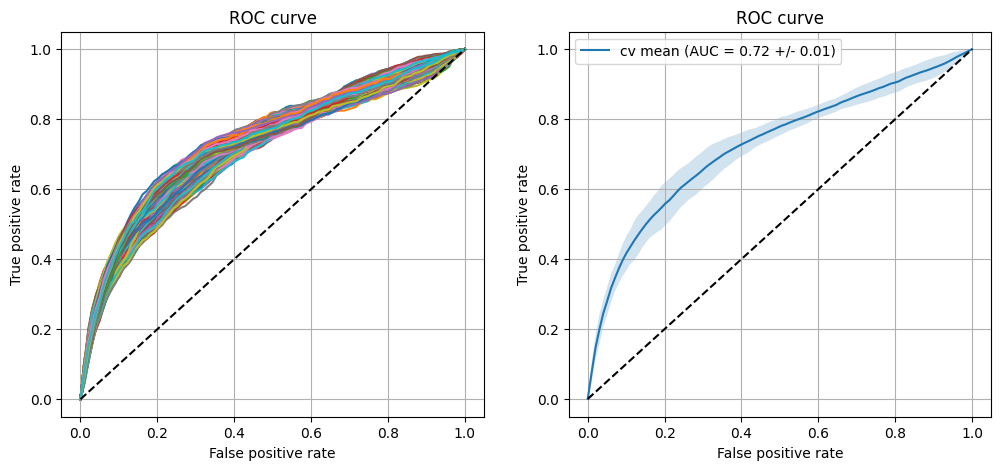

In [29]:
# for each subgoup of data, create a regressor and evaluate it
from sklearn.metrics import auc, roc_curve, roc_auc_score

n_bootstraps = 200
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)


tpr_list, auc_list, thresh_list  = [], [], []

fpr = np.linspace(0, 1, 100)
for cv, test in dataframe.groupby('cv_group'):
    # create a regressor
    test = test.dropna(subset=[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'])

    x_test = test[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
    y_test = test['label'].values
    y_pred = 1 - x_test/120

    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        fpr_, tpr_, tr_ = roc_curve(y_test[indices], y_pred[indices])
        auc_ = auc(fpr_, tpr_)

        tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tpr_))
        thresh_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tr_))
        auc_list.append(auc_)  

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr_list)):
    plt.plot(fpr, tpr_list[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
tpr_mean = np.mean(tpr_list, axis=0)
tpr_std = np.std(tpr_list, axis=0)
thr_mean = np.mean(thresh_list, axis=0)

plt.fill_between(fpr, tpr_mean - 2*tpr_std, tpr_mean + 2*tpr_std, alpha=0.2)
plt.plot(fpr, tpr_mean, label=f'cv mean (AUC = {np.mean(auc_list):.2f} +/- {pd.Series(auc_list).std():.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

# save data into a csv file
df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr_mean,
    'tpr_std': tpr_std,
    'threshold': thr_mean,
    'auc': np.round(np.mean(auc_list),2),
    'auc_std': np.round(pd.Series(auc_list).std(),2),
})
df.to_csv('data/baseline_roc.csv', index=False)


In [23]:
tpr_list[0]

array([0.        , 0.07935116, 0.14861903, 0.20341955, 0.23586146,
       0.27400263, 0.30644454, 0.33099518, 0.36256028, 0.37921964,
       0.40420868, 0.41867602, 0.43226655, 0.44848751, 0.46251644,
       0.47742218, 0.49934239, 0.51161771, 0.52652345, 0.54230601,
       0.54932047, 0.56641824, 0.58395441, 0.59973696, 0.60762823,
       0.61946515, 0.62428759, 0.6356861 , 0.64708461, 0.65322227,
       0.66199036, 0.66856642, 0.67777291, 0.68478737, 0.69180184,
       0.70056993, 0.70933801, 0.71547567, 0.72073652, 0.72775099,
       0.73301184, 0.74134152, 0.74835598, 0.75537045, 0.7606313 ,
       0.76545375, 0.76852258, 0.77466024, 0.77948268, 0.7816747 ,
       0.78474353, 0.79307321, 0.79438843, 0.79921087, 0.80534853,
       0.80710215, 0.81104779, 0.81411662, 0.82200789, 0.82683034,
       0.832968  , 0.83559842, 0.84436651, 0.84787374, 0.85094257,
       0.85839544, 0.86365629, 0.86672512, 0.86935555, 0.87286278,
       0.87724682, 0.88294608, 0.88776852, 0.89127576, 0.89302

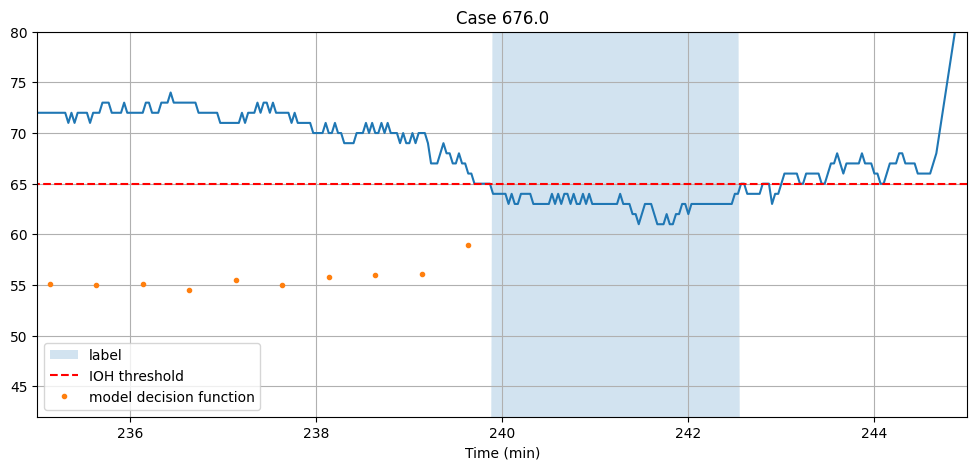

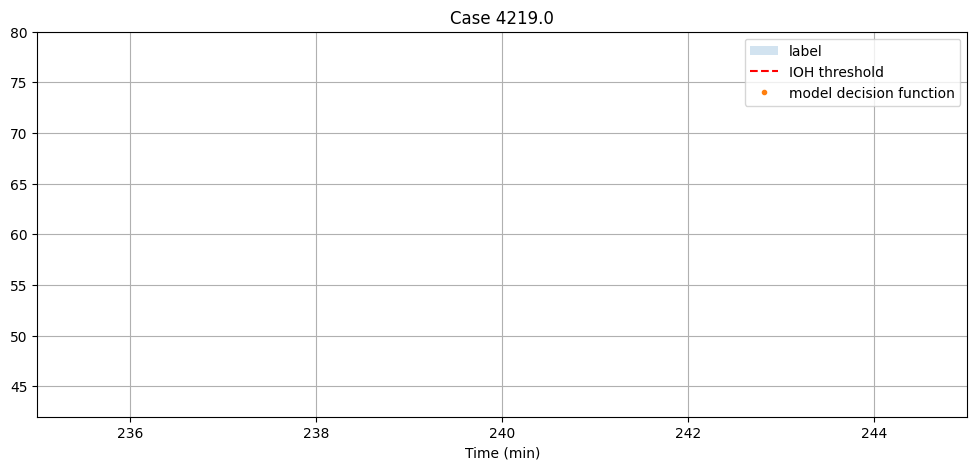

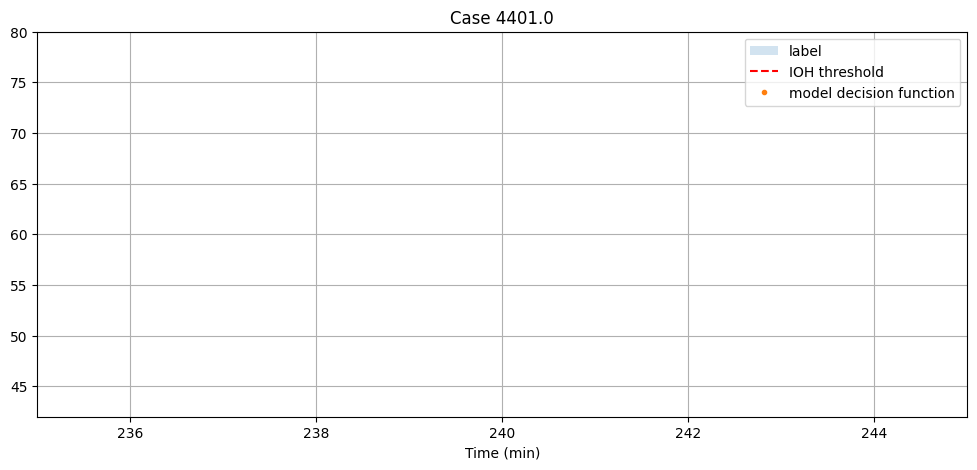

In [24]:
# plot 3 random cases with the corresponding decision function
from scripts.dataLoader import label_caseid

np.random.seed(10)
cases = np.random.choice(dataframe['caseid'].unique(), 3, replace=False)

for case in cases:
    raw_case = rawData[rawData.caseid == case].copy()
    raw_case.rename(columns={'Solar8000/ART_MBP': 'mbp'}, inplace=True)
    raw_case.mbp.mask(raw_case.mbp < 40, inplace=True)
    # removing the nan values at the beginning and the ending
    case_valid_mask = ~raw_case.mbp.isna()
    raw_case = raw_case[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]


    raw_case= label_caseid(raw_case, 2)

    segment_data = dataframe[dataframe['caseid'] == case]
    cv_group = segment_data['cv_group'].values[0]


    segment_data = segment_data.dropna(subset=[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'])
    x_test = segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
    y_test = segment_data['label'].values
    y_pred = 1 - x_test/120

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case['Time']*2/60, np.zeros(len(raw_case['Time'])), raw_case.label*100, label='label', alpha=0.2)
    plt.plot(raw_case['Time']*2/60, raw_case['mbp'])
    plt.hlines(65, raw_case['Time'].values[0]/60, raw_case['Time'].values[-1]*2/60, color='r', linestyle='--', label='IOH threshold')
    plt.plot(segment_data['time']/60,y_pred*100, '.', label='model decision function')
    # plt.plot(segment_data['time']/60, segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'], '*', label='label')
    plt.xlabel('Time (min)')
    plt.xlim([35, 42])
    plt.xlim([235, 245])
    plt.ylim([42, 80])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()



True

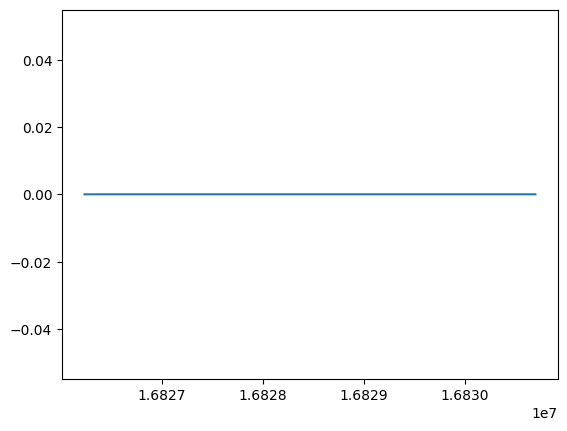

In [25]:

MIN_TIME_IOH = 60
MIN_VALUE_IOH = 65
sampling_time = 2
label1 =  raw_case.mbp.rolling(MIN_TIME_IOH//sampling_time, min_periods=1).apply(lambda x: (x<MIN_VALUE_IOH).loc[~np.isnan(x)].all() if ~x.isna().all() else False) 
label2 =  raw_case.mbp.rolling(MIN_TIME_IOH//sampling_time, min_periods=1).apply(lambda x: (x<MIN_VALUE_IOH).loc[~np.isnan(x)].all())
label2.fillna(0, inplace=True)
label2.astype(int)
label = label1 - label2

label.plot()
seg = raw_case.mbp.iloc[0:30]
~seg.isna().all()

In [26]:
raw_case.mbp

16826237     43.0
16826238     53.0
16826239     62.0
16826240     66.0
16826241     68.0
            ...  
16830692     85.0
16830693    100.0
16830694    102.0
16830695     93.0
16830696     53.0
Name: mbp, Length: 4460, dtype: float32